# Preparations

In [1]:
import torch
import torchvision
import os.path

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn import manifold
from math import exp
from torch.autograd import Variable
from my_dataset import MNIST_M
from my_dataset import ST_Dataset

%matplotlib inline
%load_ext skip_kernel_extension

In [2]:
use_gpu = torch.cuda.is_available()
print("use_gpu = " + str(use_gpu))

use_gpu = True


# Structure

![MNIST Structure](https://c1.staticflickr.com/1/978/41270649404_41480327ce_o.png)

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        self.C1 = nn.Conv2d(3, 32, 5)
        self.C2 = nn.Conv2d(32, 48, 5)
        self.FC1 = nn.Linear(48 * 4 * 4, 100)
        self.FC2 = nn.Linear(100, 100)
        self.FC3 = nn.Linear(100, 10)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2))
        # x's size is (128, 48, 4, 4)
        # flatten
        x = x.view(-1, 48 * 4 * 4)
        f = x
        # FC1
        x = F.relu(self.FC1(x))
        # FC2
        x = F.relu(self.FC2(x))
        lh = x
        # FC3
        x = self.FC3(x)
        return x, f, lh

In [4]:
cnn = CNN()
if (use_gpu):
    cnn.cuda()
print(cnn)

CNN(
  (C1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (FC1): Linear(in_features=768, out_features=100, bias=True)
  (FC2): Linear(in_features=100, out_features=100, bias=True)
  (FC3): Linear(in_features=100, out_features=10, bias=True)
)


# MNIST Dataset

Load the dataset using $\texttt{torchvision}$.

* Usage of $\texttt{transforms.Normalize(mean, std)}$:<br>
Assume that the input has $d$ channels, $\texttt{mean}$ should be a tuple of $d$ values, so should $\texttt{std}$. Let $\texttt{mean = (m1, m2, ..., md)}$ and $\texttt{std = (s1, s2, ..., sd)}$. Then the transform does $$\texttt{input[channel] = (input[channel] - mean[channel]) / std[channel]}\text{.}$$

In [5]:
import torchvision
import torchvision.transforms as transforms

In [6]:
batch_size = 128
root_dir = "./data/mnist/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, )),
    #transforms.Normalize((0.13066047712053577, ), (1, )),
    transforms.Lambda(lambda x: torch.cat((x, x, x), dim=0))
])

trainset = torchvision.datasets.MNIST(root_dir, train=True, transform=transform,
                                      target_transform=None, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset = torchvision.datasets.MNIST(root_dir, train=False, transform=transform,
                                      target_transform=None, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

Processing...
Done!


In [91]:
# this function takes the numpy input image with dim 3 x height x width
def convert_to_plt(input_image):
    input_image = input_image*np.asarray([0.5,0.5,0.5]) + np.asarray([0.5,0.5,0.5])
    return input_image

The 61th image in the first 128 images in the training set:


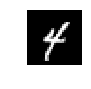

Its correspondent label:
tensor(4)


In [93]:
# randomly plot a sample from training set
import matplotlib.pyplot as plt

inputs = None
labels = None
for i, data in enumerate(trainloader):
    inputs, labels = data
    break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Training on MNIST

Or you can load the parameters directly.

In [18]:
import os.path
para_file = "./parameters/cnn_mnist.pt"
if not os.path.exists('./parameters'):
    os.makedirs('./parameters')
load_model = os.path.isfile(para_file)
print("load_model = " + str(load_model))

load_model = False


In [19]:
%%skip (not $load_model)
cnn.load_state_dict(torch.load(para_file))

### Optimizer

In [10]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Training process

In [11]:
%%skip $load_model

prev_loss = np.float("inf")
total_epoch = 30

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        break
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.229
[100] batch loss: 0.872
[150] batch loss: 0.324
[200] batch loss: 0.202
[250] batch loss: 0.187
[300] batch loss: 0.153
[350] batch loss: 0.152
[400] batch loss: 0.144
[450] batch loss: 0.097
epoch 1 loss: inf -> 219.442

[ 50] batch loss: 0.087
[100] batch loss: 0.085
[150] batch loss: 0.077
[200] batch loss: 0.063
[250] batch loss: 0.068
[300] batch loss: 0.069
[350] batch loss: 0.072
[400] batch loss: 0.082
[450] batch loss: 0.058
epoch 2 loss: 219.442 -> 34.011

[ 50] batch loss: 0.056
[100] batch loss: 0.053
[150] batch loss: 0.048
[200] batch loss: 0.043
[250] batch loss: 0.047
[300] batch loss: 0.050
[350] batch loss: 0.044
[400] batch loss: 0.053
[450] batch loss: 0.041
epoch 3 loss: 34.011 -> 22.518

[ 50] batch loss: 0.043
[100] batch loss: 0.041
[150] batch loss: 0.036
[200] batch loss: 0.034
[250] batch loss: 0.037
[300] batch loss: 0.041
[350] batch loss: 0.036
[400] batch loss: 0.042
[450] batch loss: 0.033
epoch 4 loss: 22.518 -> 17.773

[ 50] bat

In [20]:
%%skip $load_model

torch.save(cnn.state_dict(), para_file)

## Testing on MNIST

In [61]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        with torch.no_grad():
            #inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            inputs, labels = Variable(inputs), Variable(labels)
            outputs, _, _ = model(inputs)
            correct += (torch.max(outputs.data, 1)[1] == labels.data).sum().item()
            total += labels.size()[0]
    acc = correct * 1.0 / total
    return acc

In [62]:
print("Accuracy on MNIST test set (source only): " + str(evaluate_accuracy(cnn, testloader)))

Accuracy on MNIST test set (source only): 0.9908


# MNIST-M Dataset

In [63]:
from my_dataset import MNIST_M

In [64]:
batch_size = 128
root_dir = "./data/"

transform_m = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4581609321206303, 0.462350402961343, 0.4084781187671726), (1, 1, 1))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset_m = MNIST_M(root_dir, train=True, transform=transform_m, download=True)
trainloader_m = torch.utils.data.DataLoader(trainset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)
testset_m = MNIST_M(root_dir, train=False, transform=transform_m, download=True)
testloader_m = torch.utils.data.DataLoader(testset_m, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 74th image in the first 128 images in the training set:


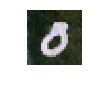

Its correspondent label:
tensor(0)


In [120]:
# randomly plot a sample from training set

inputs = None
labels = None
for i, data in enumerate(trainloader_m):
    inputs, labels = data
    break
    
idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")

plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:\n" + str(labels[idx]))

## Testing on MNIST-M Dataset (trained on source only)

In [121]:
print("Accuracy on MNIST-M test set (source only): " + str(evaluate_accuracy(cnn, testloader_m)))

Accuracy on MNIST-M test set (source only): 0.5505555555555556


## Visualization

In [27]:
from sklearn import manifold

def extract_features(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, f, l = model(inputs)
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

def visualize_single_dataset(data, labels, perplexity=50, sample_num=None):
    total_num = labels.shape[0]
    if sample_num:
        idx = np.random.choice(total_num, sample_num, replace=False)
        data, labels = data[idx, :], labels[idx]
        total_num = sample_num
    tsne = manifold.TSNE(n_components=2, init='random',
                     random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    colors = ["red", "orange", "goldenrod", "yellow", "yellowgreen", "green", "teal", "blue", "violet", "purple"]
    for i in range(10):
        plt.scatter(X[labels == i, 0], X[labels == i, 1], c=colors[i], alpha=0.4)
    plt.axis("off")
    
def visualize_da(source, target, perplexity=50, sample_num=None, save=None):
    source_num = source.shape[0]
    target_num = target.shape[0]
    if sample_num:
        source, target = source[:sample_num, :], target[:sample_num, :]
        
    data = np.vstack((source, target))

    tsne = manifold.TSNE(n_components=2, init='random',
                         random_state=0, perplexity=perplexity)
    X = tsne.fit_transform(data)
    plt.scatter(X[:sample_num, 0], X[:sample_num, 1], c="blue", edgecolors=None, alpha=0.4)
    plt.scatter(X[sample_num:, 0], X[sample_num:, 1], c="red", edgecolors=None, alpha=0.4)
    plt.axis("off")
    if save:
        plt.savefig(save)
    plt.show()
    plt.clf()
    plt.close()

In [28]:
f, lh, l = extract_features(cnn, testloader)
f_m, lh_m, l_m = extract_features(cnn, testloader_m)

### Features of MNIST test set (extracted by source only model)

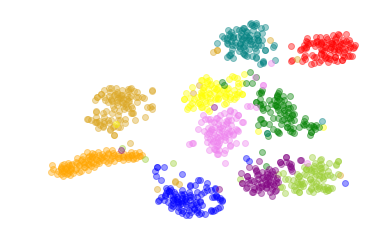

In [29]:
visualize_single_dataset(f.numpy(), l.numpy(), perplexity=50, sample_num=1000)

### Features of MNIST-M test set (extracted by source only model)

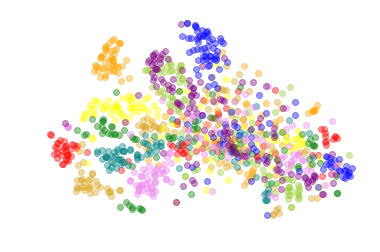

In [33]:
visualize_single_dataset(f_m.numpy(), l_m.numpy(), perplexity=50, sample_num=1000)

### Last hidden layer of MNIST test set (extracted by source only model)

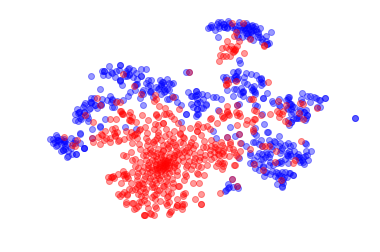

In [34]:
visualize_da(f.numpy(), f_m.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_features_NonAdapted.svg")

### Last hidden layer of MNIST-M test set (extracted by source only model)

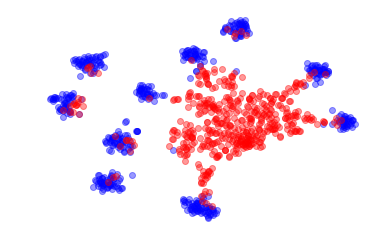

In [35]:
visualize_da(lh.numpy(), lh_m.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_lasthidden_NonAdapted.svg")

## Training on MNIST-M Dataset

In [36]:
cnn_m = CNN()
if (use_gpu):
    cnn_m.cuda()
print(cnn_m)

CNN(
  (C1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (FC1): Linear(in_features=768, out_features=100, bias=True)
  (FC2): Linear(in_features=100, out_features=100, bias=True)
  (FC3): Linear(in_features=100, out_features=10, bias=True)
)


In [41]:
para_file_m = "./parameters/cnn_mnist_m.pt"
load_model_m = os.path.isfile(para_file_m)
print("load_model_m = " + str(load_model_m))

load_model_m = False


In [42]:
%%skip (not $load_model_m)
cnn_m.load_state_dict(torch.load(para_file_m))

In [43]:
import torch.optim as optim

lr_init = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_m.parameters(), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [123]:
%%skip $load_model_m

prev_loss = np.float("inf")
total_epoch = 50

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    for i, data in enumerate(trainloader_m):
        inputs, labels = data
        if (use_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
        
        
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        outputs, _, _ = cnn_m(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        break
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.300
[100] batch loss: 2.292
[150] batch loss: 2.270
[200] batch loss: 2.130
[250] batch loss: 1.530
[300] batch loss: 0.927
[350] batch loss: 0.749
[400] batch loss: 0.576
[450] batch loss: 0.467
epoch 1 loss: inf -> 666.351

[ 50] batch loss: 0.388
[100] batch loss: 0.395
[150] batch loss: 0.340
[200] batch loss: 0.303
[250] batch loss: 0.307
[300] batch loss: 0.283
[350] batch loss: 0.291
[400] batch loss: 0.264
[450] batch loss: 0.228
epoch 2 loss: 666.351 -> 141.794

[ 50] batch loss: 0.210
[100] batch loss: 0.248
[150] batch loss: 0.219
[200] batch loss: 0.196
[250] batch loss: 0.217
[300] batch loss: 0.199
[350] batch loss: 0.217
[400] batch loss: 0.213
[450] batch loss: 0.165
epoch 3 loss: 141.794 -> 95.486

[ 50] batch loss: 0.160
[100] batch loss: 0.190
[150] batch loss: 0.170
[200] batch loss: 0.150
[250] batch loss: 0.169
[300] batch loss: 0.162
[350] batch loss: 0.163
[400] batch loss: 0.169
[450] batch loss: 0.133
epoch 4 loss: 95.486 -> 74.232

[ 50] b

[100] batch loss: 0.011
[150] batch loss: 0.007
[200] batch loss: 0.006
[250] batch loss: 0.008
[300] batch loss: 0.007
[350] batch loss: 0.006
[400] batch loss: 0.008
[450] batch loss: 0.007
epoch 34 loss: 3.596 -> 3.347

[ 50] batch loss: 0.007
[100] batch loss: 0.010
[150] batch loss: 0.006
[200] batch loss: 0.006
[250] batch loss: 0.007
[300] batch loss: 0.006
[350] batch loss: 0.005
[400] batch loss: 0.007
[450] batch loss: 0.006
epoch 35 loss: 3.347 -> 3.118

[ 50] batch loss: 0.006
[100] batch loss: 0.009
[150] batch loss: 0.006
[200] batch loss: 0.005
[250] batch loss: 0.007
[300] batch loss: 0.006
[350] batch loss: 0.005
[400] batch loss: 0.007
[450] batch loss: 0.006
epoch 36 loss: 3.118 -> 2.911

[ 50] batch loss: 0.006
[100] batch loss: 0.009
[150] batch loss: 0.006
[200] batch loss: 0.005
[250] batch loss: 0.007
[300] batch loss: 0.005
[350] batch loss: 0.005
[400] batch loss: 0.006
[450] batch loss: 0.005
epoch 37 loss: 2.911 -> 2.720

[ 50] batch loss: 0.005
[100] batch 

In [124]:
%%skip $load_model_m

torch.save(cnn_m.state_dict(), para_file_m)

In [125]:
print("Accuracy on MNIST-M test set (train on target): " + str(evaluate_accuracy(cnn_m, testloader_m)))

Accuracy on MNIST-M test set (train on target): 0.9631111111111111


# Unsupervised Domain Adaptation

## Structure (GRL)

![MNIST Structure](https://c1.staticflickr.com/1/978/41270649404_41480327ce_o.png)

In [126]:
from my_dataset import ST_Dataset

In [127]:
batch_size = 128

trainset_da = ST_Dataset(trainset, trainset_m, batch_size)
trainloader_da = torch.utils.data.DataLoader(trainset_da, batch_size=batch_size,
                                          shuffle=False, num_workers=0)

The 60th image in the first 128 images in the training set:


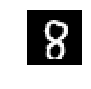

Its correspondent label:
8

From domain:
Source


In [141]:
# randomly plot a sample from test set

inputs = None
labels = None
for i, data in enumerate(trainloader_da):
    inputs, labels, domain = data
    if i == 2:
        break

idx = np.random.randint(0, batch_size)
print("The " + str(idx) + "th image in the first " + str(batch_size) +\
      " images in the training set:")
plt_img = convert_to_plt(inputs[idx].permute(1, 2, 0).cpu().data.numpy())
plt.figure(figsize=(1,1))
plt.axis("off")
plt.imshow(plt_img)
plt.show()
print("Its correspondent label:")
if labels[idx].item() == -1:
    print("I don't know :)\n")
else:
    print(str(labels[idx].item()) + "\n")

print("From domain:")
if domain[idx].item() == 0:
    print("Source")
else:
    print("Target")

In [142]:
class GRL_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, inputs, lamda):
        ctx.save_for_backward(lamda)
        return inputs

    @staticmethod
    def backward(ctx, grad_outputs):
        lamda, = ctx.saved_tensors
        return -lamda * grad_outputs, None

In [143]:
class GRL(nn.Module):
    
    def __init__(self, lamda_init):
        super(GRL, self).__init__()
        self.GRL_func = GRL_func.apply
        self.lamda = nn.Parameter(torch.Tensor(1), requires_grad=False)
        self.set_lamda(lamda_init)
        
    def forward(self, x):
        return self.GRL_func(x, self.lamda)
    
    def set_lamda(self, lamda_new):
        self.lamda[0] = lamda_new

In [144]:
class CNN_DA(nn.Module):
    
    def __init__(self, lamda_init=0):
        super(CNN_DA, self).__init__()
        # lamda
        self.lamda = lamda_init
        # feature extractor
        self.C1 = nn.Conv2d(3, 32, 5)
        self.C2 = nn.Conv2d(32, 48, 5)
        # label classifier
        self.LC_FC1 = nn.Linear(48 * 4 * 4, 100)
        self.LC_FC2 = nn.Linear(100, 100)
        self.LC_FC3 = nn.Linear(100, 10)
        # domain classifier
        self.GRL_layer = GRL(lamda_init)
        self.DC_FC1 = nn.Linear(48 * 4 * 4, 100)
        self.DC_FC2 = nn.Linear(100, 1)
        
    def forward(self, x):
        # C1
        x = F.relu(self.C1(x))
        # M1
        x = F.max_pool2d(x, (2, 2))
        # C2
        x = F.relu(self.C2(x))
        # M2
        x = F.max_pool2d(x, (2, 2))
        # x's size is (128, 48, 4, 4)
        # flatten
        x = x.view(-1, 48 * 4 * 4)
        f = x
        # label classifier
        # LC_FC1
        x_l = F.relu(self.LC_FC1(x))
        # LC_FC2
        x_l = F.relu(self.LC_FC2(x_l))
        lh = x_l
        # LC_FC3
        x_l = self.LC_FC3(x_l)
        # domain classifier
        # GRL
        x_d = self.GRL_layer(x)
        # DC_FC1
        x_d = F.relu(self.DC_FC1(x_d))
        # DC_FC2
        x_d = F.sigmoid(self.DC_FC2(x_d))
        return x_l, x_d, f, lh
    
    def set_lamda(self, lamda_new):
        self.GRL_layer.set_lamda(lamda_new)

In [145]:
def extract_features_da(model, dataloader):
    features = None
    lasthidden = None
    labels = None
    for i, data in enumerate(dataloader):
        inputs, labels_ = data
        if (use_gpu):
            inputs = inputs.cuda()
        inputs = Variable(inputs)
        _, _, f, l = model(inputs)
        if i == 0:
            features = f
            lasthidden = l
            labels = labels_
        else:
            features = torch.cat((features, f))
            lasthidden = torch.cat((lasthidden, l))
            labels = torch.cat((labels, labels_))
    features = features.data
    lasthidden = lasthidden.data
    if use_gpu:
        features = features.cpu()
        lasthidden = lasthidden.cpu()
    return features, lasthidden, labels

In [146]:
cnn_da = CNN_DA(0)
if (use_gpu):
    cnn_da.cuda()
print(cnn_da)

CNN_DA(
  (C1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (C2): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
  (LC_FC1): Linear(in_features=768, out_features=100, bias=True)
  (LC_FC2): Linear(in_features=100, out_features=100, bias=True)
  (LC_FC3): Linear(in_features=100, out_features=10, bias=True)
  (GRL_layer): GRL()
  (DC_FC1): Linear(in_features=768, out_features=100, bias=True)
  (DC_FC2): Linear(in_features=100, out_features=1, bias=True)
)


In [147]:
para_file_da = "./parameters/cnn_mnist_to_mnist_m.pt"
load_model_da = os.path.isfile(para_file_da)
print("load_model_da = " + str(load_model_da))

load_model_da = False


In [148]:
%%skip (not $load_model_da)
cnn_da.load_state_dict(torch.load(para_file_da))

### Optimizer

In [149]:
from math import exp

lr_init = 0.01
criterion_LC = nn.CrossEntropyLoss()
criterion_DC = nn.BCELoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, cnn_da.parameters()), lr=lr_init, momentum=0.9)

def adjust_lr(optimizer, p):
    global lr_init
    lr_0 = lr_init
    alpha = 10
    beta = 0.75
    lr = lr_0 / (1 + alpha * p) ** beta
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr
        
def adjust_lamda(model, p):
    gamma = 10
    lamda = 2 / (1 + exp(- gamma * p)) - 1
    model.set_lamda(lamda)
    return lamda

### Training process

In [150]:
%%skip $load_model_da

prev_loss = np.float("inf")
total_epoch = 50

for epoch in range(total_epoch):
    epoch_loss = 0.0
    running_loss = 0.0
    p = epoch * 1.0 / total_epoch
    adjust_lr(optimizer, p)
    lamda = adjust_lamda(cnn_da, p)
    for i, data in enumerate(trainloader_da):
        # get inputs
        source_size = data[0].size()[0] // 2
        inputs, labels, domains = data
        domains = domains.to(torch.float32)
        if (use_gpu):
            inputs, labels, domains = inputs.cuda(), labels.cuda(), domains.cuda()
        inputs, labels, domains = Variable(inputs), Variable(labels), Variable(domains)
        optimizer.zero_grad()
        # forward
        outputs_LC, outputs_DC, f, l = cnn_da(inputs)
        # compute loss
        outputs_DC = outputs_DC.view(-1)
        loss_LC = criterion_LC(outputs_LC[:source_size], labels[:source_size])
        loss_DC = criterion_DC(outputs_DC, domains)
        loss = loss_LC + loss_DC
        # backward
        loss.backward()
        optimizer.step()
        # stat
        epoch_loss += loss.item()
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%3d] batch loss: %.3f' %
                  (i + 1, running_loss / 50))
            running_loss = 0.0
#     f_da, lh_da, _ = extract_features_da(cnn_da, testloader)
#     f_m_da, lh_m_da, _ = extract_features_da(cnn_da, testloader_m)
#     visualize_da(f_da.numpy(), f_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/f_" + str(epoch + 1) + ".svg")
#     visualize_da(lh_da.numpy(), lh_m_da.numpy(), perplexity=30, sample_num=200,
#                  save="./pics/lh_" + str(epoch + 1) + ".svg")
    print("epoch %d loss: %.3f -> %.3f\n" % (epoch + 1, prev_loss, epoch_loss))
    if prev_loss - epoch_loss < 0.1:
        prev_loss = epoch_loss
        pass
    else:
        prev_loss = epoch_loss

[ 50] batch loss: 2.843
[100] batch loss: 1.732
[150] batch loss: 0.758
[200] batch loss: 0.483
[250] batch loss: 0.433
[300] batch loss: 0.340
[350] batch loss: 0.265
[400] batch loss: 0.305
[450] batch loss: 0.248
[500] batch loss: 0.240
[550] batch loss: 0.238
[600] batch loss: 0.211
[650] batch loss: 0.207
[700] batch loss: 0.179
[750] batch loss: 0.200
[800] batch loss: 0.168
[850] batch loss: 0.154
[900] batch loss: 0.138
epoch 1 loss: inf -> 459.420

[ 50] batch loss: 0.140
[100] batch loss: 0.137
[150] batch loss: 0.160
[200] batch loss: 0.152
[250] batch loss: 0.152
[300] batch loss: 0.161
[350] batch loss: 0.172
[400] batch loss: 0.179
[450] batch loss: 0.191
[500] batch loss: 0.157
[550] batch loss: 0.125
[600] batch loss: 0.132
[650] batch loss: 0.133
[700] batch loss: 0.123
[750] batch loss: 0.139
[800] batch loss: 0.117
[850] batch loss: 0.127
[900] batch loss: 0.111
epoch 2 loss: 459.420 -> 132.447

[ 50] batch loss: 0.119
[100] batch loss: 0.116
[150] batch loss: 0.135


[650] batch loss: 0.659
[700] batch loss: 0.647
[750] batch loss: 0.650
[800] batch loss: 0.638
[850] batch loss: 0.619
[900] batch loss: 0.642
epoch 18 loss: 611.983 -> 600.597

[ 50] batch loss: 0.635
[100] batch loss: 0.650
[150] batch loss: 0.673
[200] batch loss: 0.631
[250] batch loss: 0.635
[300] batch loss: 0.633
[350] batch loss: 0.643
[400] batch loss: 0.647
[450] batch loss: 0.660
[500] batch loss: 0.648
[550] batch loss: 0.648
[600] batch loss: 0.674
[650] batch loss: 0.653
[700] batch loss: 0.633
[750] batch loss: 0.662
[800] batch loss: 0.639
[850] batch loss: 0.633
[900] batch loss: 0.634
epoch 19 loss: 600.597 -> 594.803

[ 50] batch loss: 0.641
[100] batch loss: 0.661
[150] batch loss: 0.703
[200] batch loss: 0.625
[250] batch loss: 0.619
[300] batch loss: 0.616
[350] batch loss: 0.626
[400] batch loss: 0.667
[450] batch loss: 0.672
[500] batch loss: 0.622
[550] batch loss: 0.632
[600] batch loss: 0.646
[650] batch loss: 0.677
[700] batch loss: 0.645
[750] batch loss: 

[250] batch loss: 0.642
[300] batch loss: 0.620
[350] batch loss: 0.645
[400] batch loss: 0.644
[450] batch loss: 0.652
[500] batch loss: 0.643
[550] batch loss: 0.647
[600] batch loss: 0.668
[650] batch loss: 0.649
[700] batch loss: 0.675
[750] batch loss: 0.668
[800] batch loss: 0.659
[850] batch loss: 0.642
[900] batch loss: 0.657
epoch 36 loss: 596.149 -> 599.769

[ 50] batch loss: 0.639
[100] batch loss: 0.633
[150] batch loss: 0.651
[200] batch loss: 0.640
[250] batch loss: 0.648
[300] batch loss: 0.656
[350] batch loss: 0.652
[400] batch loss: 0.653
[450] batch loss: 0.650
[500] batch loss: 0.690
[550] batch loss: 0.693
[600] batch loss: 0.709
[650] batch loss: 0.710
[700] batch loss: 0.693
[750] batch loss: 0.729
[800] batch loss: 0.635
[850] batch loss: 0.629
[900] batch loss: 0.637
epoch 37 loss: 599.769 -> 611.085

[ 50] batch loss: 0.685
[100] batch loss: 0.660
[150] batch loss: 0.663
[200] batch loss: 0.661
[250] batch loss: 0.684
[300] batch loss: 0.643
[350] batch loss: 

In [151]:
%%skip $load_model_da

torch.save(cnn_da.state_dict(), para_file_da)

### Test on MNIST and MNIST-M dataset

In [153]:
def evaluate_da_accuracy(model, dataloader, source):
    model.eval()
    correct_LC = 0
    correct_DC = 0
    total = 0
    
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, labels = data
            if (use_gpu):
                inputs, labels = inputs.cuda(), labels.cuda()
            inputs, labels = Variable(inputs), Variable(labels)
            outputs_LC, outputs_DC, _, _ = model(inputs)
            correct_LC += (torch.max(outputs_LC.data, 1)[1] == labels.data).sum().item()
            if source:
                correct_DC += labels.size()[0] - outputs_DC.data.sum().item()
            else:
                correct_DC += outputs_DC.data.sum().item()
            total += labels.size()[0]
        acc_LC = correct_LC / total
        acc_DC = correct_DC / total
    return acc_LC, acc_DC

In [154]:
print(("Label classifier accuracy on MNIST test set (DA): %f\n"
       "Domain classifier accuracy on MNIST test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader, source=True))

Label classifier accuracy on MNIST test set (DA): 0.983300
Domain classifier accuracy on MNIST test set (DA): 0.577271


In [155]:
print(("Label classifier accuracy on MNIST-M test set (DA): %f\n"
       "Domain classifier accuracy on MNIST-M test set (DA): %f")
      %evaluate_da_accuracy(cnn_da, testloader_m, source=True))

Label classifier accuracy on MNIST-M test set (DA): 0.827333
Domain classifier accuracy on MNIST-M test set (DA): 0.437314


### Visualization

In [156]:
f_da, lh_da, l_da = extract_features_da(cnn_da, testloader)
f_m_da, lh_m_da, l_m_da = extract_features_da(cnn_da, testloader_m)

Features of MNIST test set (extracted by DA model)

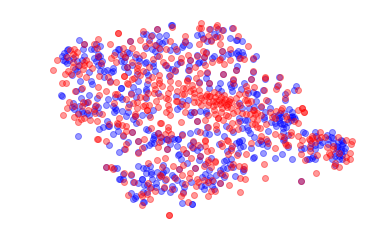

In [157]:
visualize_da(f_da.numpy(), f_m_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_features_Adapted.svg")

Features of MNIST-M test set (extracted by DA model)

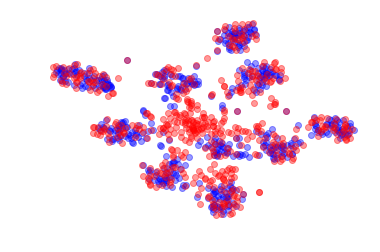

In [158]:
visualize_da(lh_da.numpy(), lh_m_da.numpy(), perplexity=50, sample_num=500,
             save="./pics/MNIST_to_MNIST_M_lasthidden_Adapted.svg")